# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "marius_bartel"
ln1 = "samo_kamga"
fn2 = "zakaria"
ln2 = "tozy"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_samo_kamga_marius_bartel_and_tozy_zakaria.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

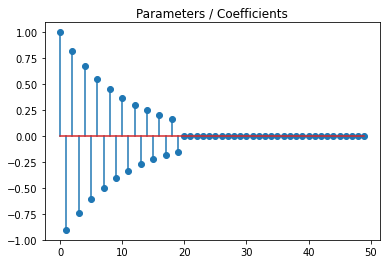

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
np.random.seed(0)

In [7]:
A, b = simu_linreg(coefs)
#A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression
n = A.shape[0]

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [8]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x""" 
    return np.sign(x) * np.maximum(np.abs(x)-lmbd,0) # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, 1) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x / (1 + lmbd) # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * (np.linalg.norm(x, 2)**2 / 2) # TODO


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

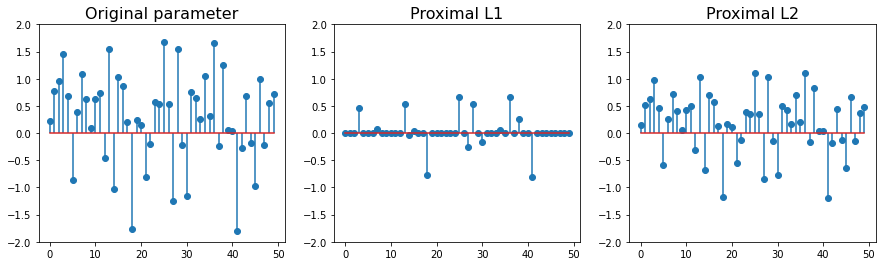

In [9]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x,use_line_collection=True)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1),use_line_collection=True)
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2),use_line_collection=True)
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>


- The Proximal L1 operator convert the input vector into a sparse vector, all the components of the input vector smaller that $\lambda$ in absolute value are set to zero, all components greater than $\lambda$ are reduce by $\lambda$ and all components smaller than $-\lambda$ are increase by $\lambda$.In other term
only the "most significant" coefficients are kept, all the others set to 0.

- The Proximal L2 operator scale down the input vector by a factor $\frac{1}{1+\lambda}$ 

The two are used to avoid overfitting

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

## Gradiant of Linear regression : 
$$ \nabla_x f(x) = \nabla_x( \frac{1}{2n} \|b - Ax \|_2^2)  $$
$$ \nabla_x f(x) = \frac{1}{n} A^T (Ax - b)$$ 

## Gradiant of Logistic regression :
$$ f(x) =\frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)) $$
$$ \nabla_x f(x) = \left( \frac{1}{n} \sum\limits_{i=1}^{n} \frac{-b_ia_{ik}}{\left( 1 + e^{b_ia_i^Tx}\right)} \right)_{k \in [1,m]} $$

### 1-) Losses and Gradients

In [10]:
# Losses and Gradients
#from locale import ABDAY_3

def loss_linreg(x):
    """Least-squares loss"""
    return (np.linalg.norm(b - A @ x, 2)**2)/ (2*n) # TODO

def grad_linreg(x):
    """Leas-squares gradient"""
    return -1/n * np.dot(A.T,(b-np.dot(A,x))) # TODO

def loss_logreg(x):
    """Logistic loss"""
    return (1/n) * np.sum(np.log(1 + np.exp(-b * (A @ x)))) # TODO

def grad_logreg(x):
    """Logistic gradient"""
    return (1/n) * (A.T @ (b * der_logexp( (A @ x)*b))) # TODO

#Compute the derivative of log(1+exp(x))
def der_logexp(x) : 
   return - (1 / (1 + np.exp(x)))

# TO BE COMPLETED

### 2-) Validation of the Gradients

In [11]:
# Checking if the gradients are well computed
from scipy.optimize import check_grad
a = np.random.randn(n_features)

A, b = simu_linreg(coefs)
print(check_grad(loss_linreg, grad_linreg, a))

A, b = simu_logreg(coefs)
print(check_grad(loss_logreg, grad_logreg, a))

3.959772381483724e-06
1.305994044607934e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [12]:
# TO BE COMPLETED

from numpy.linalg import norm

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss""" 
    return (norm(A, ord=2)**2 )/ n

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss""" 
    return (norm(A, ord=2)**2) / (4 * n)
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=200,x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""

    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_R(x - (grad_f(x) / step), lmbd / step) 
        ####
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [13]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=200,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)

    t = 1.
    t_new = 1.    

    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO #### FISTA
        x_new = prox_R(z -(grad_f(z)/ step), lmbd / step)
        t_new = (1 + np.sqrt(1 + 4*(t**2)))/2
        z = x_new +  ((t - 1) / t_new) * (x_new - x) 

        x = x_new
        t = t_new
        ####

        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [14]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [15]:
# Computing and precise minimizer and minimum
A, b = simu_linreg(coefs)
x_optim, objectives_optim, errors_optim = APGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm,prox_R=prox_L2, 
                                               step=smoothness_const_linreg(A),lmbd=lmbd, n_iter=1000, verbose=False)

print(f"A precise minimum with the given parameters is {objectives_optim[-1]}")

A precise minimum with the given parameters is 0.5033266350852447


The precise minimizer is **x_optim**

In [16]:
x_apgd_l2, objectives_apgd_l2, errors_apgd_l2 = APGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm,prox_R=prox_L2, 
                                                     step=smoothness_const_linreg(A), x_true=x_optim,lmbd=lmbd, n_iter=1000,
                                                     verbose=False)

x_pgd_l2, objectives_pgd_l2, errors_pgd_l2 = PGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm,prox_R=prox_L2, 
                                                 step=smoothness_const_linreg(A), x_true=x_optim,lmbd=lmbd, n_iter=1000,
                                                 verbose=False)


## Comparison of PGD and APDG

- In term of distance to the minimum: 
The APD goes faster to the minimum than the PGD, duo to the accelaration(momemtum) and that's why we also observe oscillation. Also it's a linear convergence for the PGD
- In term of distance to the minimizer:  
The error function of PGD is monotone and guarantees that at each step the minimizer is better than the previous one we have a linear convergence. A contrario the error function of the APGD is not monotone , but it's also converge to the minimizer .

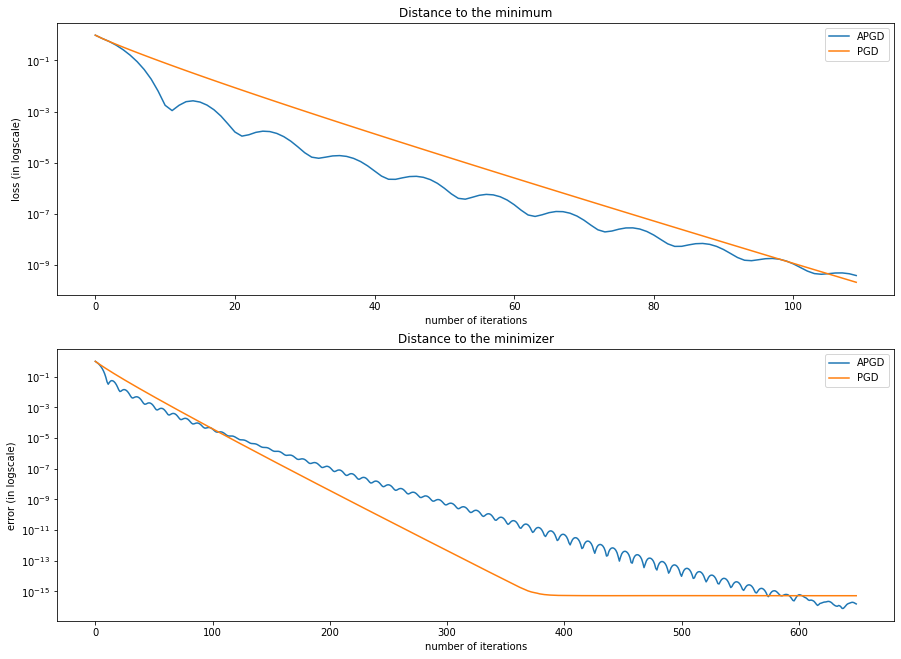

In [17]:
# Visualization
plt.figure(figsize=(15,11))

#Visualization to the distance to the minimum
plt.subplot(2,1,1)
plt.plot(objectives_apgd_l2[:110] - objectives_optim[-1], label = "APGD")
plt.plot(objectives_pgd_l2[:110]- objectives_optim[-1], label= "PGD")
plt.title("Distance to the minimum")
plt.xlabel("number of iterations")
plt.ylabel("loss (in logscale)")
plt.yscale("log")
plt.legend()

#Visualization to the distance to the minimizer
plt.subplot(2,1,2)
plt.title("Distance to the minimizer")
plt.plot(errors_apgd_l2[:650] , label = "APGD")
plt.plot(errors_pgd_l2[:650], label= "PGD")
plt.xlabel("number of iterations")
plt.ylabel("error (in logscale)")
plt.yscale("log")
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

#### Comparison of the PGD and the APGD with the true Parameter 

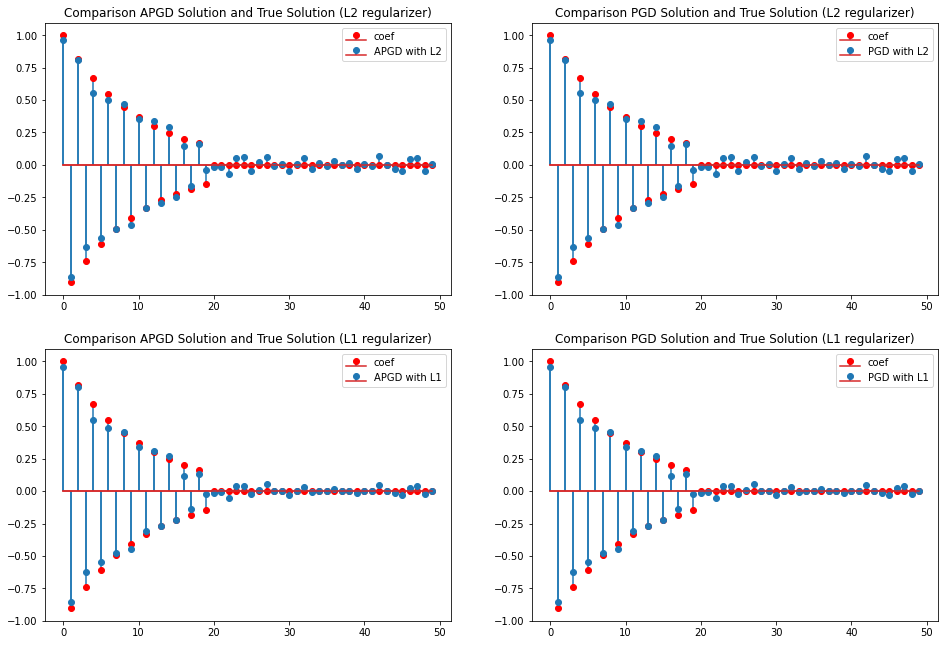

In [18]:
x_apgd_l1, objectives_apgd_l1, errors_apgd_l1 = APGD(x0=x0, f=loss_linreg, grad_f=grad_linreg,R=L1_norm,prox_R=prox_L1,
                                                     step=smoothness_const_linreg(A),x_true=x_optim,lmbd=lmbd,n_iter=1000, 
                                                     verbose=False)

x_pgd_l1, objectives_pgd_l1, errors_pgd_l1 = PGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L1_norm,prox_R=prox_L1, 
                                                 step=smoothness_const_linreg(A), x_true=x_optim,lmbd=lmbd, n_iter=1000, 
                                                 verbose=False)

plt.figure(figsize=(16,11))

plt.subplot(2,2,1)
plt.stem(coefs, label="coef", markerfmt="or",use_line_collection=True)
plt.stem(x_apgd_l2, label = "APGD with L2",use_line_collection=True)
plt.legend()
plt.title("Comparison APGD Solution and True Solution (L2 regularizer)")

plt.subplot(2,2,2)
plt.stem(coefs, label="coef", markerfmt="or",use_line_collection=True)
plt.stem(x_pgd_l2, label = "PGD with L2",use_line_collection=True)
plt.legend()
plt.title("Comparison PGD Solution and True Solution (L2 regularizer)")

plt.subplot(2,2,3)
plt.stem(coefs, label="coef", markerfmt="or",use_line_collection=True)
plt.stem(x_apgd_l1, label = "APGD with L1",use_line_collection=True)
plt.legend()
plt.title("Comparison APGD Solution and True Solution (L1 regularizer)")

plt.subplot(2,2,4)
plt.stem(coefs, label="coef", markerfmt="or",use_line_collection=True)
plt.stem(x_pgd_l1, label = "PGD with L1",use_line_collection=True)
plt.legend()
plt.title("Comparison PGD Solution and True Solution (L1 regularizer)")

plt.show()

- We observe that for the same regularizer the solution of APGD and PGD are similar
- If we focus on the same method either APGD or PGD the solution with the regulazizer Lasso are a little 
bit more smaller than the one of the Ridge, $\lambda$ is really small in this example so the difference is not really obvious

### For the study of the impact of correlation we use the linear loss with the Lasso

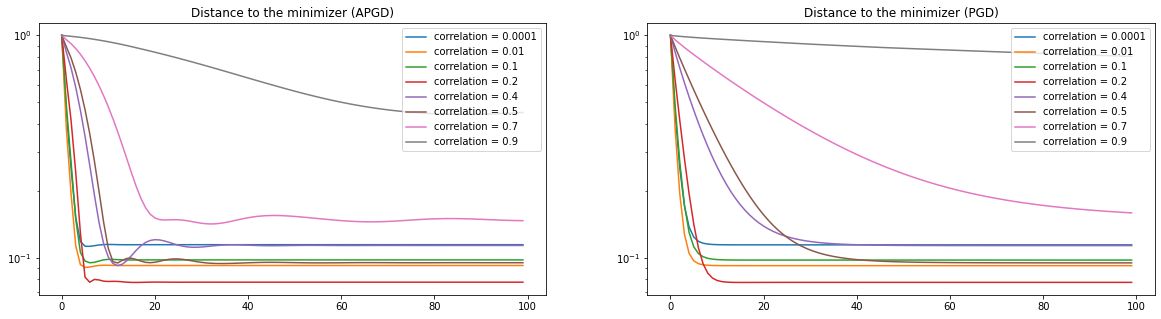

In [19]:
correlation = [0.0001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.7, 0.9]
plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,2,1)
plt.title("Distance to the minimizer (APGD)")
plt.yscale("log")
plt.legend()

ax2 = plt.subplot(1,2,2)
plt.title("Distance to the minimizer (PGD)")
plt.yscale("log")
plt.legend()


for corr in correlation:
    A, b = simu_linreg(coefs=coefs, corr=corr)

    x_apgd, objectives_apgd, errors_apgd = APGD(x0=x0,f=loss_linreg, grad_f=grad_linreg, R=L1_norm,prox_R=prox_L1,
                                                step=smoothness_const_linreg(A), x_true=coefs,lmbd=lmbd, n_iter=1000, 
                                                verbose=False)
    
    x_pgd, objectives_pgd, errors_pgd = PGD(x0=x0,f=loss_linreg, grad_f=grad_linreg, R=L1_norm,prox_R=prox_L1,
                                                step=smoothness_const_linreg(A), x_true=coefs,lmbd=lmbd, n_iter=1000,
                                                verbose=False)
    
    ax1.plot(errors_apgd[:100], label = f"correlation = {corr}")
    ax1.legend()
    ax2.plot(errors_pgd[:100], label= f"correlation = {corr}")
    ax2.legend()
    

###The influence of the correlation of the features on the performance of the optimization algorithms : 

We can observe than the higher is the correlation, slower are the algorithm and higher are the final error. On the other hand smaller the correlation is more the algorithm is efficient. This is really the problem of multicollinearity in regression model. 

Explaination:  
- if we have a simple model where we have 2 features : $x = (x_1, x_2)$ and we try to predict the label with a linear model : $y = a_0 + a_1x_1 + a_2x_2$

- if there is a strong correlation between $x_1$ and $x_2$ so strong that $x_1 = c x_2$ where c is a constant.

The model $y = a_0  + a_1x_1 + a_2x_2 =  a_0  + (a_1c + a_2)x_2$ can have the same prediction whatever $ a = (a_1, a_2)$ and this for an infinite vectors a 



### For the study of the impact of the $\lambda$ parameter we will use the logistic loss with Ridge 

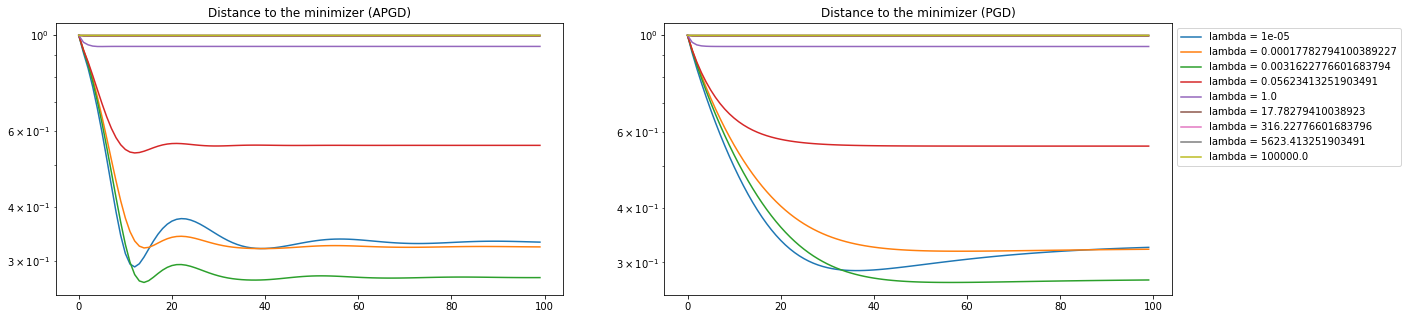

In [20]:
lmbd = np.logspace(start=-5, stop=5, base=10.0, num=9)
plt.figure(figsize=(20,5))
ax1 = plt.subplot(1,2,1)
plt.title("Distance to the minimizer (APGD)")
plt.yscale("log")


ax2 = plt.subplot(1,2,2)
plt.title("Distance to the minimizer (PGD)")
plt.yscale("log")


for i in lmbd :
    A, b = simu_logreg(coefs=coefs)
    x_apgd, objectives_apgd, errors_apgd = APGD(x0=x0, f=loss_logreg, grad_f=grad_logreg, R=L2_norm,prox_R=prox_L2, step=smoothness_const_loreg(A),
                                                x_true=coefs,lmbd=i, n_iter=1000, verbose=False)
    x_pgd, objectives_pgd, errors_pgd = PGD(x0=x0, f=loss_logreg, grad_f=grad_logreg, R=L2_norm,prox_R=prox_L2, step=smoothness_const_loreg(A), 
                                            x_true=coefs,lmbd=i, n_iter=1000, verbose=False)

    ax1.plot(errors_apgd[:100], label = f"$\lambda$ = {i}") 
    plt.legend(bbox_to_anchor=(1,1))  

    ax2.plot(errors_pgd[:100], label= f"lambda = {i}")
    plt.legend(bbox_to_anchor=(1,1))

### The influence of the level of penalization ( 𝜆 ) on the performance of the optimization algorithms : 
We can observe : 
- When the regularizer parameter $\lambda$ is too high the algorithm tend to focus just on the penalization term for example in this case will L2 that will to find a point w from which the L2 norm is close to zero 
- Reducing the penalization, and finding a good tradeoff avoid overfiting.The coefficients of the minimizer are shrink to zero when they are too big, for the L2 penalization we decrease by $\frac{1}{1+\lambda}$ 


